In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

In [2]:
# pandas를 이용하여 excel파일의 데이터를 가져옵니다. 321일치의 데이터가 있음을 확인해 볼 수 있습니다.
d = pd.read_excel('C:\\Users\mingu\Desktop\\2020_covid19_KR_seoul.xlsx')
print(d.shape)

(321, 16)


In [3]:
# 각각의 feature들의 이름을 출력하여 봅시다.
col_names = list(d.columns)
i = 0
for n in col_names:
    print(f'feature {i}: {n}')
    i=i+1

feature 0: date
feature 1: retail_and_recreation_percent_change_from_baseline
feature 2: grocery_and_pharmacy_percent_change_from_baseline
feature 3: parks_percent_change_from_baseline
feature 4: transit_stations_percent_change_from_baseline
feature 5: workplaces_percent_change_from_baseline
feature 6: residential_percent_change_from_baseline
feature 7: seoul_retail_and_recreation_percent_change_from_baseline
feature 8: seoul_grocery_and_pharmacy_percent_change_from_baseline
feature 9: seoul_parks_percent_change_from_baseline
feature 10: seoul_transit_stations_percent_change_from_baseline
feature 11: seoul_workplaces_percent_change_from_baseline
feature 12: seoul_residential_percent_change_from_baseline
feature 13: confirmed_new
feature 14: deaths_new
feature 15: recovered_new


In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 16 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   date                                                      321 non-null    datetime64[ns]
 1   retail_and_recreation_percent_change_from_baseline        321 non-null    int64         
 2   grocery_and_pharmacy_percent_change_from_baseline         321 non-null    int64         
 3   parks_percent_change_from_baseline                        321 non-null    int64         
 4   transit_stations_percent_change_from_baseline             321 non-null    int64         
 5   workplaces_percent_change_from_baseline                   321 non-null    int64         
 6   residential_percent_change_from_baseline                  321 non-null    int64         
 7   seoul_retail_and_recreation_percent_change_f

In [5]:
d[d['date'].duplicated()]

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,seoul_retail_and_recreation_percent_change_from_baseline,seoul_grocery_and_pharmacy_percent_change_from_baseline,seoul_parks_percent_change_from_baseline,seoul_transit_stations_percent_change_from_baseline,seoul_workplaces_percent_change_from_baseline,seoul_residential_percent_change_from_baseline,confirmed_new,deaths_new,recovered_new


In [6]:
# target : 새로 확진된 사람의 수 - feature 13: confirmed_new
# 13번째 feature인 새로 확진된 사람의 숫자를 y(target)로 합니다.
# 우리는 1주 전의 데이터를 통해 1주 후를 예측하고자 하므로, 7번째 날짜부터의 데이터를 y로 가져오겠습니다.
y = d.iloc[7:,13].to_numpy()
print(y.shape)

(314,)


In [7]:
# train set 설정
# 몇 개의 feature를 선정하여 input data X로 가져오겠습니다.
# 마지막 7일치 데이터는 target이 존재하지 않으므로, 이는 빼고 가져오도록 합니다.
X = d.iloc[:-7,[1,3,4,7,8,9,10,12]].to_numpy()
print(X.shape)

(314, 8)


In [8]:
# model 학습에 사용하기 위해 X, y를 모두 pytorch의 floattensor로 변환합니다.
X = torch.tensor(X).type(torch.FloatTensor)
y = torch.tensor(y).type(torch.FloatTensor)

In [9]:
# floattensor X의 shape 출력
X.shape

torch.Size([314, 8])

In [10]:
# floattensor y의 shape 출력
y.shape

torch.Size([314])

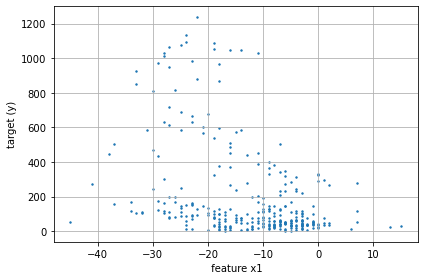

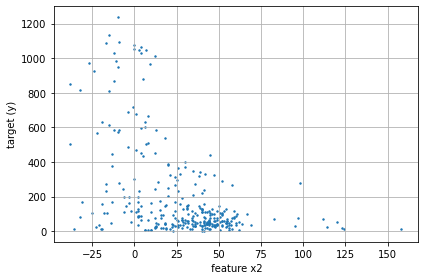

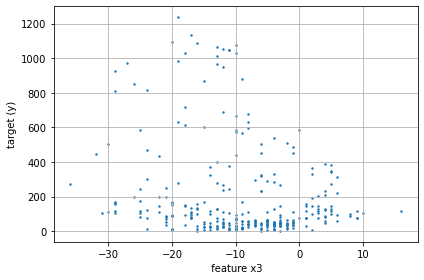

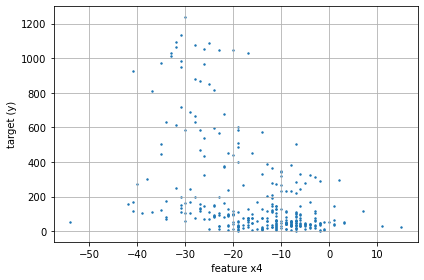

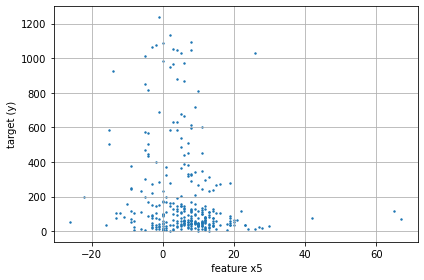

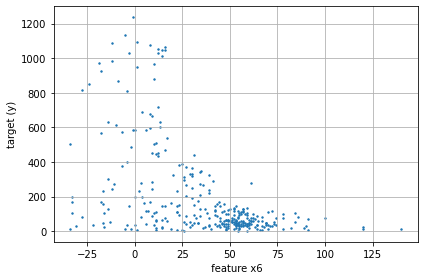

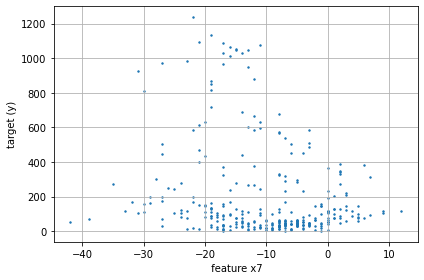

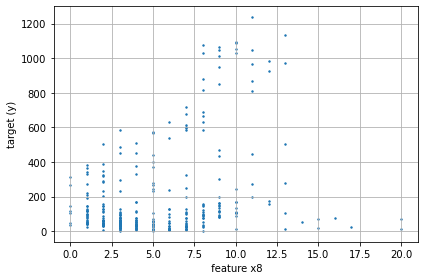

In [11]:
# 각각의 feature와 y의 관계를 그래프로 확인합니다.
for n in range(X.shape[-1]):
    plt.scatter(X[:,n],y,2)
    plt.xlabel(f' feature x{n+1}')
    plt.ylabel('target (y)')
    plt.grid('on')
    plt.tight_layout()
    plt.show()

### 파이썬코드 작성 및 실행 ###
- 불러온 데이터에 대해 학습을 진행할 수 있도록 필요한 model, loss function, optimization algorithm, data loader를 정의하고, 적절한 하이퍼파라미터를 설정하여 모델을 학습시켜 봅니다.
- 아래의 실습코드를 참고하여 네 개의 함수를 정의하고 하이퍼파라미터들을 학습결과를 보며 최적화합니다.
- 학습결과가 만족스럽지 않은 경우 input feature의 종류를 변경하여 X를 다시 구성해봅시다.
- 아래 세 개의 cell에 코드를 넣어 진행하는 것을 권장하지만 필요시 새로운 cell을 추가하여도 괜찮습니다.

In [12]:
### 필요한 함수들의 정의 (model, loss, algorithm, data loader) ###

## 1.Linear Regression model 생성
# y = XW + b
# retrun predictions(= y_hat)

def lin_model(X, W, b): 
    return torch.matmul(X, W) + b

## 2.loss 함수 생성
# squared loss : ((predictions - labels)^2) / 2
# y는 torch.Size가 ([314]), y_hat은 matmmul 연산으로 인해 torch.Size가 ([314, 1])이므로 연산을 위해 reshape()함수 사용
# y를 y_hat의 shape으로 만들어서 연산

def loss(y_hat, y):  
    return (y_hat - y.reshape(y_hat.shape))**2 / 2


## 3.optimization algorithm 정의
# Minibatch stochastic gradient descent
# parameter(W,b) / learning_rate / batch_size 를 인수로 받음
# parameter(W,b) 업데이트

def sgd(W, b, lr, batch_size):  
    # with torch.no_grad() 구문 내에서는 gradient 연산 옵션을 꺼줌
    # sgd 함수 호출 순간의 gradient를 사용하겠다는 의미
    with torch.no_grad():
        W -= lr * W.grad / batch_size         # W.grad : W의 gradient 
        W.grad.zero_()                        # W의 gradient 0으로 초기화
        
        b -= lr * b.grad / batch_size         # b.grad : b의 gradient 
        b.grad.zero_()                        # b의 gradient 0으로 초기화
            

## 4.data loader 정의
# 학습데이터 X와 label y, batch_size를 인수로 받음
# 학습데이터의 길이(314)를 num_examples로 받음
# num_example의 range 리스트(0~313)를 indices로 받음
# indices를 random으로 섞음 - 데이터의 순서가 섞임

def data_iter(batch_size, X, y):
    num_examples = len(X)                     
    indices = list(range(num_examples))        
    random.shuffle(indices)                    
    
    # 학습을 위해 데이터를 batch_size 크기로 나눠서 받음
    # 전체 데이터를 한바퀴 순회함 : 1 epoch
    # batch_indices에 랜덤하게 섞은 indices를 슬라이싱해서 인덱스를 받아줌
    # 민약 i + batch_size가 총 데이터의 길이보다 길어지면 마지막 데이터까지만 받아옴
    # ex) i = 310, batch_size = 10이면 마지막에는 인덱스 310:314 까지만 슬라이싱해서 받음
    # yield 로 batch_size만큼의 X와 y를 반환해줌 
    
    for i in range(0, num_examples, batch_size): 
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield X[batch_indices], y[batch_indices]

In [13]:
### model parameter 초기화 및 하이퍼파라미터 설정 ###

## parameter 초기화
# 각 parameter 업데이트를 위해 requires_grad = True 설정
# requires_grad = True 설정으로 W.grad와 b.grad에 각 parameter의 gradient가 저장되어 gradient로 사용가능함
# X와의 matrix multiplication 을 위해 X의 열의 개수와 W의 행의 개수를 맞춰줌

W = torch.zeros((8,1), requires_grad = True)        # Weight 초기값 0으로 설정
b = torch.zeros(1, requires_grad = True)            # bias 초기값 0으로 설정


## hyper parameter 설정

lr = 0.0001                  # learning rate 설정
num_epochs = 100000          # 시행횟수 설정
batch_size = 50              # 배치 사이즈 설정

In [14]:
### for loop를 이용한 model의 학습 ###

# 총 시행횟수 num_epochs 동안 for문 실행
# data_iter 함수의 반환값 X[batch_indices], y[batch_indices]를 각각 batch_features, batch_labels으로 받아서 squared loss 연산 진행
for epoch in range(num_epochs):
    for batch_features, batch_labels in data_iter(batch_size, X, y):
        l = loss(lin_model(batch_features, W, b), batch_labels)  
        
        # Compute gradient on `l` with respect to [`w`, `b`]
        #.backward()를 호출하여 loss에 대한 W와 b의 gradient를 계산하고 저장함
        l.sum().backward()
        
        # sgd함수 - parameter(W,b) 업데이트
        sgd(W, b, lr, batch_size)
        
    # with torch.no_grad() 구문 내에서는 학습가능한 parameter들을 업데이트 하지 않음
    # W, b의 업데이트 없음
    # train_l에 loss값을 받아서 epoch 1000번당 한번씩 loss의 평균을 출력함
    with torch.no_grad():                              
        train_l = loss(lin_model(X, W, b), y)  

        if epoch%1000==0:
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 38003.773438
epoch 1001, loss 19245.431641
epoch 2001, loss 18821.029297
epoch 3001, loss 18648.062500
epoch 4001, loss 18526.097656
epoch 5001, loss 18416.160156
epoch 6001, loss 18331.574219
epoch 7001, loss 18309.513672
epoch 8001, loss 18262.779297
epoch 9001, loss 18163.675781
epoch 10001, loss 18105.550781
epoch 11001, loss 18062.162109
epoch 12001, loss 18037.730469
epoch 13001, loss 17990.671875
epoch 14001, loss 17955.503906
epoch 15001, loss 17950.166016
epoch 16001, loss 17901.486328
epoch 17001, loss 17969.207031
epoch 18001, loss 17857.318359
epoch 19001, loss 17855.457031
epoch 20001, loss 17865.449219
epoch 21001, loss 17844.386719
epoch 22001, loss 17793.798828
epoch 23001, loss 17787.296875
epoch 24001, loss 17769.037109
epoch 25001, loss 17760.599609
epoch 26001, loss 17780.378906
epoch 27001, loss 17744.501953
epoch 28001, loss 17740.691406
epoch 29001, loss 17746.818359
epoch 30001, loss 17791.466797
epoch 31001, loss 17717.105469
epoch 32001, loss 177

### 결과요약
- input feature 및 hyperparameter 들의 선정이 완료되어 최종 모델이 학습되면 아래와 같은 결과를 출력하여 노트북파일을 저장하고 제출합니다. 
- 결과는 아래 3가지를 반드시 포함하여 출력하도록 합니다.
    1. 314개 example들에 대한 loss의 평균, 
    2. 314개 example에 대한 label, prediction의 scatter plot, 
    3. 학습이 완료된 model의 weight들의 값

average loss: 17668.511719


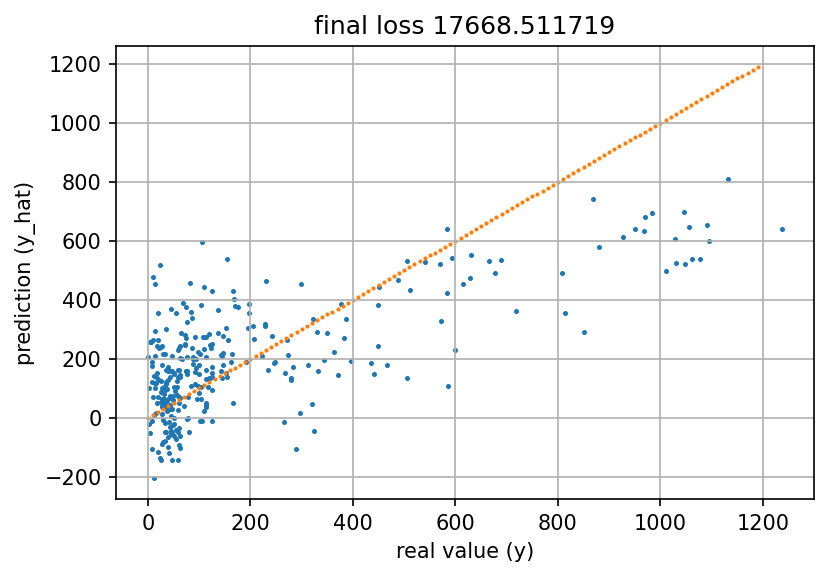

W: tensor([[ 21.0286],
        [ -5.6660],
        [ 11.9505],
        [-26.1676],
        [  0.5967],
        [ -0.3037],
        [ 10.0532],
        [ 48.4699]])
b: tensor([177.4695])


In [16]:
# with torch.no_grad() - requires_grad = True 인 Tensor(weight, bias)의 업데이트를 멈춤
# linear regression model의 결과값을 y_hat(prediction) 으로 받음
# train_l에 loss를 받아서 loss의 평균을 출력함  
with torch.no_grad():
    y_hat = lin_model(X, W, b)
    train_l = loss(y_hat, y)
    print(f'average loss: {float(train_l.mean()):f}')

# scatter plot 생성
# x축에 실제 label(y) 값, y축에 prediction(y_hat) 값을 찍어줌. 점의 size는 2로 설정
# x축과 y축에 np.arange()함수를 이용해서 0~1200 구간의 배열을 간격 10을 기준으로 찍어줌. 점의 size는 1로 설정
# .grid('on') 옵션으로 배경에 격자무늬 생성
plt.figure(dpi=150)
plt.scatter(y,y_hat,2)
plt.scatter(np.arange(0,1200,10),np.arange(0,1200,10),1)
plt.grid('on')

# x축 이름, y축 이름, scatter plot의 이름 설정
plt.xlabel('real value (y)')
plt.ylabel('prediction (y_hat)')
plt.title(f'final loss {float(train_l.mean()):f}')
plt.show()

# 각 weight들의 값과 bias 값 출력
# .dethach()를 사용해 기존 Tensor에서 gradient 업데이트가 일어나지 않는 텐서를 생성하여 출력
print('W:',W.detach())
print('b:',b.detach())